<a href="https://colab.research.google.com/github/obsaa1/obsaa1/blob/main/image_caption_for_afaan_oromoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Afaan oromo caption generation from image using attention based deep learning**

this project takes some images and generate their caption in afaan oromo language


In [3]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import os
import tensorflow as tf
import keras
import keras.utils
from keras import utils as np_utils
import sys
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))

print("tensorflow version {}".format(tf.__version__))
from tensorflow.keras.preprocessing import image

python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
keras version 2.12.0
tensorflow version 2.12.0


In [8]:
image_dataset_path = '/content/drive/MyDrive/Datasets/Flickr8k Images (8091 files)'
caption_dataset_path = '/content/drive/MyDrive/Datasets/English_language__captions.txt'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


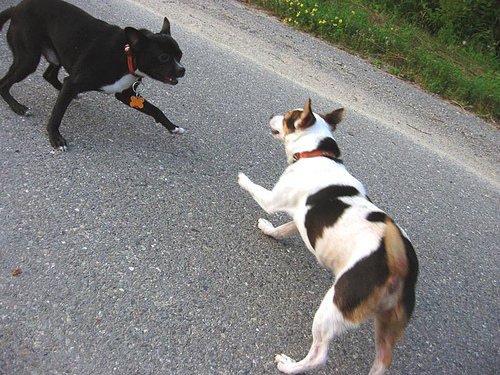

In [10]:
from IPython.display import Image
Image('/content/drive/MyDrive/Datasets/Flickr8k Images (8091 files)/1001773457_577c3a7d70.jpg')

**A caption processor typically refers to the part of the model responsible for generating captions.**

In [11]:
# load the caption file & read it
def load_caption_file(path):

    # dictionary to store captions
    captions_dict = {}

    # iterate through the file
    for caption in open(path):

        # caption has format-> 1000268201_693b08cb0e.jpg#0  A child in a pink dress is climbing up a set of stairs in an entry way .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)

        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text

    return captions_dict

# call the function
captions_dict = load_caption_file(caption_dataset_path)

***1) Convert the captions into lowercase:***

This step involves converting all characters in the captions to lowercase. This is done to ensure consistency and reduce the vocabulary size by treating words in different cases (e.g., "The" and "the") as the same word. For example, the caption "A Child is Playing" would become "a child is playing".

***2) Tokenize the captions into different tokens***:

Tokenization is the process of breaking down a sentence or text into individual words or tokens. In this step, you take the lowercase captions and split them into individual words. This is crucial for further processing and modeling. For example, the caption "a child is playing" would be tokenized into individual tokens: ["a", "child", "is", "playing"].

***3) Remove all the punctuations from the tokens:***

Punctuation marks (such as periods, commas, exclamation marks, etc.) are removed from the tokens. This helps in simplifying the vocabulary and focusing on the core words. For example, if a token is "playing,", it will be converted to "playing".

***4) Add "start_index" and "end_index" as pointers:***

To help the model understand the beginning and end of captions, special tokens are added. The "start_index" token indicates the start of the caption, and the "end_index" token indicates the end. These tokens are used as markers when training the model to generate captions. For instance, if the tokenized caption is ["a", "child", "is", "playing"], after adding the "start_index" and "end_index" tokens, it would become ["start_index", "a", "child", "is", "playing", "end_index"].

After performing these preprocessing steps, you'll have tokenized, lowercase captions with special tokens at the beginning and end. These preprocessed captions can then be used as input for training your captioning model.

In [12]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [13]:
del captions_dict

In [14]:
print('"' + list(new_captions_dict.keys())[7] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[7]])

"1009434119_febe49276a" : startseq black and white dog is running in grassy garden surrounded by white fence endseq


In [15]:
print('"' + list(new_captions_dict.keys())[6] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[6]])

"1007320043_627395c3d8" : startseq child playing on rope net endseq


In [16]:
print('"' + list(new_captions_dict.keys())[8] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[8]])

"1012212859_01547e3f17" : startseq dog shakes its head near the shore red ball next to it endseq


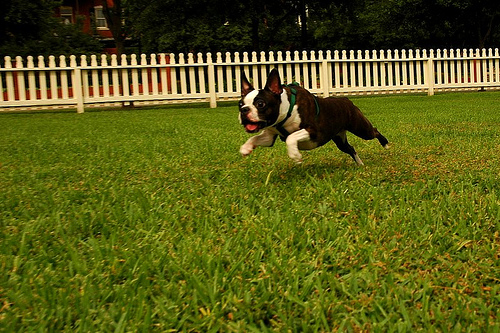

In [17]:
Image('/content/drive/MyDrive/Datasets/Flickr8k Images (8091 files)/1009434119_febe49276a.jpg')

In [18]:
len(new_captions_dict)


8092

***Creating training, validation, and test datasets***
#Creating training, validation, and test datasets is a fundamental step in machine learning and deep learning. These datasets are used to train, tune, and evaluate your model's performance. Here's how to create these datasets:

1. Training Dataset:
The training dataset is the largest portion of your data and is used to train your model. It's where your model learns the patterns and relationships between inputs (images) and outputs (captions). The training dataset should be diverse and representative of the data you expect to encounter in real-world scenarios.

2. Validation Dataset:
The validation dataset is used to fine-tune your model and tune hyperparameters. It helps you monitor how well your model is performing during training without overfitting to the training data. It's important to note that the validation data should be separate from the training data and not used for training.

3. Test Dataset:
The test dataset is used to evaluate the final performance of your trained model. It's used to simulate how well your model will perform on new, unseen data. Similar to the validation data, the test data should also be completely separate from the training and validation data.

Here's a step-by-step guide to creating these datasets:

***Splitting the Data:***
Decide on the proportions in which you want to split your data into training, validation, and test sets. Common ratios are 70-15-15, 80-10-10, or 60-20-20, depending on the size of your dataset.

**Randomization:** *italicized text*
Shuffle your data randomly to ensure that each set (training, validation, test) has a representative mix of samples.

***Creating the Splits:***
Divide your shuffled data into the predefined proportions for each set. You can use tools like Python's train_test_split function from the sklearn.model_selection module to split your data.**

In [19]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(image_dataset_path) if image.split('.')[0] in image_index ]

In [22]:
train_validate_images = caption_images_list[0:8081]
test_images = caption_images_list[8081:8091]
test_images

['3518687038_964c523958',
 '2892467862_52a3c67418',
 '1478606153_a7163bf899',
 '3353400143_8b9543f7dc',
 '3657209354_cde9bbd2c5',
 '3034585889_388d6ffcc0',
 '624058168_f1c5e87e59',
 '2521938720_911ac092f7',
 '3123463486_f5b36a3624',
 '3677302645_8cd3fac70d']

In [23]:
caption_images_list[0]

'652542470_60e858da64'

In [24]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()

    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize
    print(model.summary())

    # extract features from each photo
    features = dict()

    for name in image_keys:

        # load an image from file
        filename = directory + '/' + name + '.jpg'

        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]

        # store feature
        features[image_id] = feature

#         print('>%s' % name)

    return features

## Pre-Trained Image Model (VGG16)

The following creates an instance of the VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already.

The VGG16 model was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for the image classification.

If `include_top=True` then the whole VGG16 model is downloaded which is about 528 MB. If `include_top=False` then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

We will use some of the fully-connected layers in this pre-trained model, so we have to download the full model, but if you have a slow internet connection, then you can try and modify the code below to use the smaller pre-trained model without the classification layers.

Tutorials #08 and #10 explain more details about Transfer Learning.

In [2]:
# extracting image features for train_validate_images
train_validate_features = extract_features(image_dataset_path, train_validate_images)

NameError: ignored

In [1]:
transfer_layer = train_validate_features.get_layer('fc2')

NameError: ignored

Importing the converted afaan oromoo image dataset and its respective captions

# New Section

In [ ]:

dir_Flickr_jpg1 = "/content/drive/MyDrive/Colab Notebooks/Datasets/flkrTrain"

# Get a list of image paths within the directory
image_filenames = os.listdir(dir_Flickr_jpg1)
image_paths = [os.path.join(dir_Flickr_jpg1, filename) for filename in image_filenames]

# Define a function to preprocess a batch of images
def preprocess_images(image_paths, target_size=(224, 224)):
    preprocessed_images = []
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        preprocessed_images.append(img_array)
    return np.vstack(preprocessed_images)

# Preprocess and extract features for the batch of images
preprocessed_images = preprocess_images(image_paths)
image_features = vgg16_model.predict(preprocessed_images)

NameError: ignored

In [ ]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Load the VGG16 model pre-trained on ImageNet
vgg16_model = VGG16(weights='imagenet', include_top=False)

# Load the Flickr8k dataset and preprocess the captions
# ... (load captions and corresponding image paths, preprocess captions)

# Preprocess images using VGG16
def preprocess_image(dir_Flickr_jpg1, target_size=(224, 224)):
    img = image.load_img(dir_Flickr_jpg1, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Example usage
image_path = 'path_to_your_image.jpg'
preprocessed_img = preprocess_image(image_path)
image_features = vgg16_model.predict(preprocessed_img)

# Define parameters
vocab_size = len(word_to_index)
max_caption_length = 15
embedding_dim = 256
hidden_units = 512

# Define the attention mechanism
# ... (you can use BahdanauAttention or LuongAttention)

# Define the captioning model
input_image_features = Input(shape=(image_features.shape[1],))
image_features_dense = Dense(embedding_dim, activation='relu')(input_image_features)

input_caption = Input(shape=(max_caption_length,))
caption_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_caption)

# Define the BiLSTM layer
bi_lstm = Bidirectional(LSTM(hidden_units, return_sequences=True))(caption_embedding)

# Apply attention to the BiLSTM output and image features
# ... (use the attention mechanism to combine image and caption features)

# Concatenate attention output and BiLSTM output
merged_features = Concatenate(axis=-1)([attention_output, bi_lstm])

# Generate caption using a Dense layer
output_caption = Dense(vocab_size, activation='softmax')(merged_features)

# Compile the model
captioning_model = Model(inputs=[input_image_features, input_caption], outputs=output_caption)
captioning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare input data
# ... (prepare input image features, captions, and target captions)

# Train the model
captioning_model.fit([input_image_features_train, input_captions_train], target_captions_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Generate captions using the trained model
# ... (use the trained model to generate captions for test images)

FileNotFoundError: ignored

In [ ]:
jpgs = os.listdir(dir_Flickr_jpg1)
print("The number of jpg files file for training in Flicker8k: {}".format(len(jpgs)))

In [ ]:
# Set the paths for the original dataset and the destination directories
original_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/Flickr8k Images (8091 files)'
train_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/flkrTrain'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/flkrTest'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/flkrValidation'

# Set the desired proportions for training, testing, and validation sets
train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

# Get the list of JPG files in the original directory
jpg_files = [file for file in os.listdir(original_dir) if file.endswith('.jpg')]

# Shuffle the file list
random.shuffle(jpg_files)

# Calculate the number of files for each set
num_files = len(jpg_files)
num_train = int(num_files * train_ratio)
num_test = int(num_files * test_ratio)
num_validation = num_files - num_train - num_test

# Split the files into training, testing, and validation sets
train_files = jpg_files[:num_train]
test_files = jpg_files[num_train:num_train + num_test]
validation_files = jpg_files[num_train + num_test:]

# Move the files to the destination directories
for file in train_files:
    shutil.copyfile(os.path.join(original_dir, file), os.path.join(train_dir, file))
for file in test_files:
    shutil.copyfile(os.path.join(original_dir, file), os.path.join(test_dir, file))
for file in validation_files:
    shutil.copyfile(os.path.join(original_dir, file), os.path.join(validation_dir, file))

# Print the number of files in each set
print("Number of files in training set: {}".format(len(train_files)))
print("Number of files in testing set: {}".format(len(test_files)))
print("Number of files in validation set: {}".format(len(validation_files)))

Number of files in training set: 6472
Number of files in testing set: 809
Number of files in validation set: 810


In [ ]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = dir_Flickr_jpg.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = dir_Flickr_jpg.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)

    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

In [ ]:
show_image(idx=1, train=True)

AttributeError: ignored

In [ ]:
captionText = os.listdir(dir_Flickr_text)
print("The number of jpg files in Flicker8k: {}".format(len(captionText)))

NotADirectoryError: ignored